In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib

from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Plots import lens_plot, plot_util
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Util import param_util, image_util
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy.Util.param_util as param_util
from multiprocessing import Pool


from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
import lenstronomy.ImSim.de_lens as de_lens
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
# Import PySwarms
import pyswarms as ps
import copy
import pickle

from astropy.cosmology import Planck15 as cosmo

nmax = 14

cnk = 1

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}
matplotlib.rc('font', **font)

deltaPix = 0.031230659851709842*cnk  #  pixel size in arcsec (area per pixel = deltaPix**2)
exp_time = 1.
sigma_bkg = 1.

#######################################################

# Import the JWST images and error files
file_path = "/n/home02/nephremidze/cab_survey/abell-s1063/f150w/data/"

array200sci = np.load(file_path+'f150w_image1_.npy')
array200err = np.load(file_path+'f150w_error1_.npy')

array200sci2 = np.load(file_path+'f150w_image2_.npy')
array200err2 = np.load(file_path+'f150w_error2_.npy')

array200sci3 = np.load(file_path+'f150w_image3_.npy')
array200err3 = np.load(file_path+'f150w_error3_.npy')


##############################
for i in range(len(array200err)):
    for j in range(len(array200err)):
        if array200err[i,j] == 0:
            array200err[i,j] = np.inf
        if array200err2[i,j] == 0:
            array200err2[i,j] = np.inf
        if array200err3[i,j] == 0:
            array200err3[i,j] = np.inf
##############################

def rechunk(array2d,nchunk):
    shp = np.shape(array2d)
    shpnew = [int(q/nchunk) for q in shp]
    arraynew = np.zeros(shpnew)
    
    for i in range(shpnew[0]):
        for j in range(shpnew[1]):
            for k in range(nchunk):
                for l in range(nchunk):
                    arraynew[i,j] += array2d[i*nchunk+k,j*nchunk+l]/(nchunk**2.) 
    return arraynew

def rechunkerr(array2d,nchunk):
    shp = np.shape(array2d)
    shpnew = [int(q/nchunk) for q in shp]
    arraynew = np.zeros(shpnew)
    
    for i in range(shpnew[0]):
        for j in range(shpnew[1]):
            acc = 0.
            for k in range(nchunk):
                for l in range(nchunk):
                    acc += (array2d[i*nchunk+k,j*nchunk+l]/(nchunk**2.))**2.
            arraynew[i,j] = np.sqrt(acc)
    return arraynew

arytst = rechunk(array200sci,cnk)
arytst2 = rechunk(array200sci2,cnk)
arytst3 = rechunk(array200sci3,cnk)

arytsterr = rechunkerr(array200err,cnk)
arytsterr2 = rechunkerr(array200err2,cnk)
arytsterr3 = rechunkerr(array200err3,cnk)

numPix2 = int(120/cnk)

kernel_cut = np.load("/n/home02/nephremidze/cab_survey/abell-s1063/psf_calculation/jwst_psf_150_sim.npy")

psf_type = 'PIXEL'  # 'GAUSSIAN', 'PIXEL', 'NONE'

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix/cnk,'kernel_point_source': kernel_cut}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)

psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

kwargs_data2 = sim_util.data_configure_simple(numPix2, deltaPix, exp_time, sigma_bkg)
data_class2 = ImageData(**kwargs_data2)


def makemask(array,a,b,angle):
    #makes an elliptical mask of a size and angle
    shp = np.shape(array)
    
    likemask = np.zeros(shp,dtype=bool)
    for i in range(shp[0]):
        for j in range(shp[1]):
            xprim = np.cos(angle)*(i-shp[0]/2.) + np.sin(angle)*(j-shp[1]/2.)
            yprim = np.cos(angle)*(j-shp[1]/2.) - np.sin(angle)*(i-shp[0]/2.)
            sqrsum = (xprim/a)**2 + (yprim/b)**2. 
            if sqrsum < 1:
                likemask[i,j] = True
    return likemask

def convert_params(mur,mut):
    #take in the tangential and radial magnification
    #return kappa and gamma
    kappa = 1. - 0.5*(1./mur + 1./mut)
    gamma = 0.5*(1./mur - 1./mut)
    return kappa,gamma

# THE CORRECT MASK FOR A-S1063 
likemask = makemask(arytst,30./cnk,70./cnk,0.8)
likemask2 = makemask(arytst2,30/cnk,70./cnk,1.7)
likemask3 = makemask(arytst3,30./cnk,70./cnk,0.5)

def flatten2d(arrays,likemasks):
    #flattens a set of arrays according to likemasks
    flatarr = []
    for i in range(len(likemasks)):
        for p in range(len(likemasks[i])):
            for q in range(len(likemasks[i])):
                if likemasks[i][p,q]:
                    flatarr.append(arrays[i][p,q])  
    return flatarr

def unflatten(flatimg,likemasks):
    arrays = np.zeros([len(likemasks),len(likemasks[0]),len(likemasks[0])])
    k = 0
    for i in range(len(likemasks)):
        for p in range(len(likemasks[i])):
            for q in range(len(likemasks[i])):
                if likemasks[i][p,q]:
                    arrays[i,p,q] = flatimg[k]
                    k+=1
    return arrays

imagearr = np.array([arytst3,arytst2,arytst])
noises = np.array([arytsterr3,arytsterr2,arytsterr])
likemasks = np.array([likemask3,likemask2,likemask])
likearr = likemasks

flatarr = flatten2d(imagearr,likemasks)
flaterror = flatten2d(noises,likemasks)

indices = [0,1,2]

for i in range(len(flaterror)):
    if flaterror[i] == 0:
        flaterror[i] = np.inf

unflatimg = unflatten(flatarr,likemasks)


def model_curved_fit_shapelet_sers(data,kappashear_params,source_params,kwargs_lens_light,likemask_list,indices):   
    
    A_list = []
    C_D_response_list = []
    d_list = []
    
    for i in indices:
        if i == 1:
            lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST','NFW']
            
        else:
            lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST']
        
        kwargs_lens_true_new = kappashear_params[i]

        lens_model_class = LensModel(lens_model_list=lens_model_list_new)

        source_model_list = ['SHAPELETS']
        source_model_class = LightModel(light_model_list=source_model_list)
        
        lens_light_reconstruct = LightModel(['SERSIC'])
        
        data_class2.update_data(data[i])
        
        imageModel = ImageLinearFit(data_class=data_class2, 
                                    psf_class=psf_class, 
                                    kwargs_numerics=kwargs_numerics, 
                                    lens_model_class=lens_model_class,
                                    source_model_class=source_model_class,
                                    lens_light_model_class=lens_light_reconstruct,
                                    likelihood_mask=likemask_list[i])
        
        
        A = imageModel._linear_response_matrix(kwargs_lens_true_new, 
                                               source_params, 
                                               kwargs_lens_light[i], 
                                               kwargs_ps=None)
        C_D_response, model_error = imageModel._error_response(kwargs_lens_true_new, kwargs_ps=None,kwargs_special=None)
        d = imageModel.data_response
        
        A_list.append(A)
        
        Ashp = np.shape(A)
        
        C_D_response_list.append(C_D_response)
        d_list.append(d)
    
    Ashp = np.shape(A)
        
    
    Atot = np.concatenate((A_list),axis=1)
    Ctot = np.concatenate((C_D_response_list))
    Dtot = np.concatenate((d_list))
    
    param, cov_param, wls_model2 = de_lens.get_param_WLS(Atot.T, 1./Ctot, Dtot, inv_bool=False)
    
    return wls_model2,param

ndeg = np.count_nonzero(likemasks)


# THE PRIORS
# THE PRIORS
maxlens1 = [   5.,0.2,0.6]
minlens1 = [   1.,-0.2,0.2]

maxlens2 = [0.,3.,0.3,0.2]
minlens2 = [-2.,1.,-0.1,0.]

maxlens3 = [2.,4.,0.5,0.4]
minlens3 = [0.5,1.,-0.6,0.1]

maxshift = [0.5,0.5]
minshift = [-0.5,-0.5]

maxshape = [2.5,0.2,0.2]
minshape = [0.,-0.2,-0.2]

# The NFW perturber priors

xpp = 0.0
ypp = 0.0


maxnfw = [10000.,500.,xpp+0.73,ypp+0.07]
minnfw = [0.,1.,xpp+0.63,ypp-0.07]

maxsers = [2.0, 8.]
minsers = [0., 0.164]

maxparam = maxlens1 + maxlens2 + maxshift + maxlens3 + maxshift + maxshape + maxnfw + maxsers
minparam = minlens1 + minlens2 + minshift + minlens3 + minshift + minshape + minnfw + minsers

npar = len(minparam)


def lnlike(params):      

    mur1, mut1 = 1.,params[0]
    mur2, mut2 = params[3],params[4]
    mur3, mut3 = params[9],params[10]
    
    cv1 = np.abs(params[1])
    cv2 = np.abs(params[5])
    cv3 = np.abs(params[11])

    psi_ext1 = params[2]*np.pi - (np.sign(params[1])+1.)*np.pi/2.
    psi_ext2 = params[6]*np.pi - (np.sign(params[5])+1.)*np.pi/2.
    psi_ext3 = params[12]*np.pi - (np.sign(params[11])+1.)*np.pi/2.
    
    # lensing quantities
    Mpert = params[18]*1e7
    Cpert = params[19]

    z_s = 1.398
    z_l = 0.348
    
    R_sers = params[22]
    n_sers = params[23]

    lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Mpert, c=Cpert)

    kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                      {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                       'center_x': 0., 'center_y': 0.}],
                     [{'alpha_x':params[7],'alpha_y':params[8]},
                      {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                       'center_x': 0., 'center_y': 0.},
                       {'Rs':Rs_angle, 'alpha_Rs':alpha_Rs, 'center_x':params[21], 'center_y':params[20]}],
                     [{'alpha_x':params[13],'alpha_y':params[14]},
                      {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                       'center_x': 0., 'center_y': 0.}]]

    source_shape = [{'n_max': nmax, 'beta': params[15]/np.power(nmax+1,0.5), 'center_x': params[16], 'center_y': params[17]}]
    
    kwargs_lens_light = [[{'R_sersic': 0., 'n_sersic': 1.0, 'center_x': 0., 'center_y': 0.}],
                         [{'R_sersic': R_sers, 'n_sersic': n_sers, 'center_x': params[21], 'center_y': params[20]}],
                         [{'R_sersic': 0., 'n_sersic': 1.0, 'center_x': 0., 'center_y': 0.}]]

    fit,paramq = model_curved_fit_shapelet_sers(imagearr,kwargs_kapshe,source_shape,kwargs_lens_light,likearr,indices)

    return -0.5*np.sum((((fit-flatarr)/flaterror)**2.))


# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    return minparam*(1.-u) + maxparam*u


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
dresults = load_obj(f'POINT_MASS_NFW_FIT_POSA_with_10_8_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax{nmax}')


def plot_true_source(source_kwargs,param):
    # data specifics
    exp_time = 1000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix = int(720)  #  cutout pixel size
    deltaPix = 0.002  #  pixel size in arcsec (area per pixel = deltaPix**2)
    fwhm = 4e-2  # full width half max of PSF (only valid when psf_type='gaussian')
    psf_type = 'NONE'  # 'GAUSSIAN', 'PIXEL', 'NONE'
    # generate the psf variables
    kernel_cut = np.zeros([15,15])
    kernel_cut[7,7] = 1.
    kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm, 'kernel_point_source':kernel_cut}
    #kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
    psf_class = PSF(**kwargs_psf)
    
    # generate the coordinate grid and image properties
    kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
    kwargs_data['exposure_time'] = exp_time * np.ones_like(kwargs_data['image_data'])
    data_class = ImageData(**kwargs_data)
    # keywords for PixelGrid() class used in plotting routines
    kwargs_pixel_grid = {'nx': numPix, 'ny': numPix, 'transform_pix2angle': kwargs_data['transform_pix2angle'],
                         'ra_at_xy_0': kwargs_data['ra_at_xy_0'], 'dec_at_xy_0': kwargs_data['dec_at_xy_0']}
 
    # the lens model is a supperposition of an elliptical lens model with external shear
    lens_model_list_new = []
    kwargs_lens_true_new = []

    lens_model_class = LensModel(lens_model_list=lens_model_list_new)

    source_model_list = ['SHAPELETS']
    source_model_class = LightModel(light_model_list=source_model_list)
    
    source_params0 = copy.deepcopy(source_kwargs[0])  # Assuming the first dictionary in the list
    source_params0['amp'] = param[:]
    print(source_params0)
    print(np.shape(param))

    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, kwargs_numerics=kwargs_numerics)

    # generate image
    image_sim = imageModel.image(kwargs_lens_true_new, [source_params0])
        
    return image_sim

def visualize(params):    
    mur1, mut1 = 1.,params[0]
    mur2, mut2 = params[3],params[4]
    mur3, mut3 = params[9],params[10]
    
    cv1 = np.abs(params[1])
    cv2 = np.abs(params[5])
    cv3 = np.abs(params[11])

    psi_ext1 = params[2]*np.pi - (np.sign(params[1])+1.)*np.pi/2.
    psi_ext2 = params[6]*np.pi - (np.sign(params[5])+1.)*np.pi/2.
    psi_ext3 = params[12]*np.pi - (np.sign(params[11])+1.)*np.pi/2.
    
    # lensing quantities
    Mpert = params[18]*1e7
    Cpert = params[19]

    z_s = 1.398
    z_l = 0.348
    
    R_sers = params[22]
    n_sers = params[23]

    lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Mpert, c=Cpert)

    kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                      {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                       'center_x': 0., 'center_y': 0.}],
                     [{'alpha_x':params[7],'alpha_y':params[8]},
                      {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                       'center_x': 0., 'center_y': 0.},
                       {'Rs':Rs_angle, 'alpha_Rs':alpha_Rs, 'center_x':params[21], 'center_y':params[20]}],
                     [{'alpha_x':params[13],'alpha_y':params[14]},
                      {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                       'center_x': 0., 'center_y': 0.}]]

    source_shape = [{'n_max': nmax, 'beta': params[15]/np.power(nmax+1,0.5), 'center_x': params[16], 'center_y': params[17]}]
    
    kwargs_lens_light = [[{'R_sersic': 0., 'n_sersic': 1.0, 'center_x': 0., 'center_y': 0.}],
                         [{'R_sersic': R_sers, 'n_sersic': n_sers, 'center_x': params[21], 'center_y': params[20]}],
                         [{'R_sersic': 0., 'n_sersic': 1.0, 'center_x': 0., 'center_y': 0.}]]
    
    fit,paramq = model_curved_fit_shapelet_sers(imagearr,kwargs_kapshe,source_shape,kwargs_lens_light,likearr,indices)
    
    lnlout = -0.5*np.sum((((fit-flatarr)/flaterror)**2.))
    
    sourcefit = plot_true_source(source_shape,paramq)
    unflatfit = unflatten(fit,likearr)
    return  unflatfit,sourcefit,lnlout


def bestfit(result):
    #takes in the result, returns best fit and errors
    #and returns -logl
    logs = result.logl
    samps = result.samples
    argmax = np.argmax(logs)
    
    weights = np.exp(result.logwt - result.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samps, weights)
    
    errs = [cov[i,i] for i in range(len(mean))]
    
    return logs[argmax],samps[argmax],np.sqrt(errs)*2. 


maxl, bestf, cv = bestfit(dresults)
imagevis, sourcevis,lnl  = visualize(bestf)

{'n_max': 14, 'beta': 0.11800885081631418, 'center_x': -0.020158135492783252, 'center_y': 0.18166454340512206, 'amp': array([ 7.42029599e+02,  1.19119229e+02,  2.53161475e+01, -6.54008416e+00,
       -3.27949373e+02,  2.51375211e+02,  2.13473524e+01,  6.48567921e+00,
       -7.64838146e+01,  1.03712498e+02,  6.40276633e+01,  1.16469664e+02,
        1.41558099e+02, -1.03878463e+02,  6.47562204e+01,  4.86910742e+01,
       -5.81022508e+01,  8.37591215e+01,  2.22116106e+01, -2.29740435e+01,
       -2.34064035e+01,  3.77739902e+01, -1.02527389e+02, -5.47090153e+01,
       -2.93119418e+01,  6.03673897e+01,  2.62043232e+01,  1.64084271e+01,
       -2.44715614e+01,  1.24448124e+01, -2.57221804e-01, -4.49844143e+01,
        4.07548012e+01, -6.87374518e+00,  7.15091813e+01,  2.79181204e+00,
        2.50680333e+00,  1.23273440e+01,  8.01626546e+01,  1.50078397e+00,
        3.13289693e+01, -3.09069086e+01,  2.14598611e+01, -1.71813775e+01,
        3.97832195e+01,  4.57615432e+01, -1.47456475e+01,

221.0398767303112
487.87058577467184
0.6880271975011429
-0.0017974470450180802
0.6644603654103444
0.29147885151077324


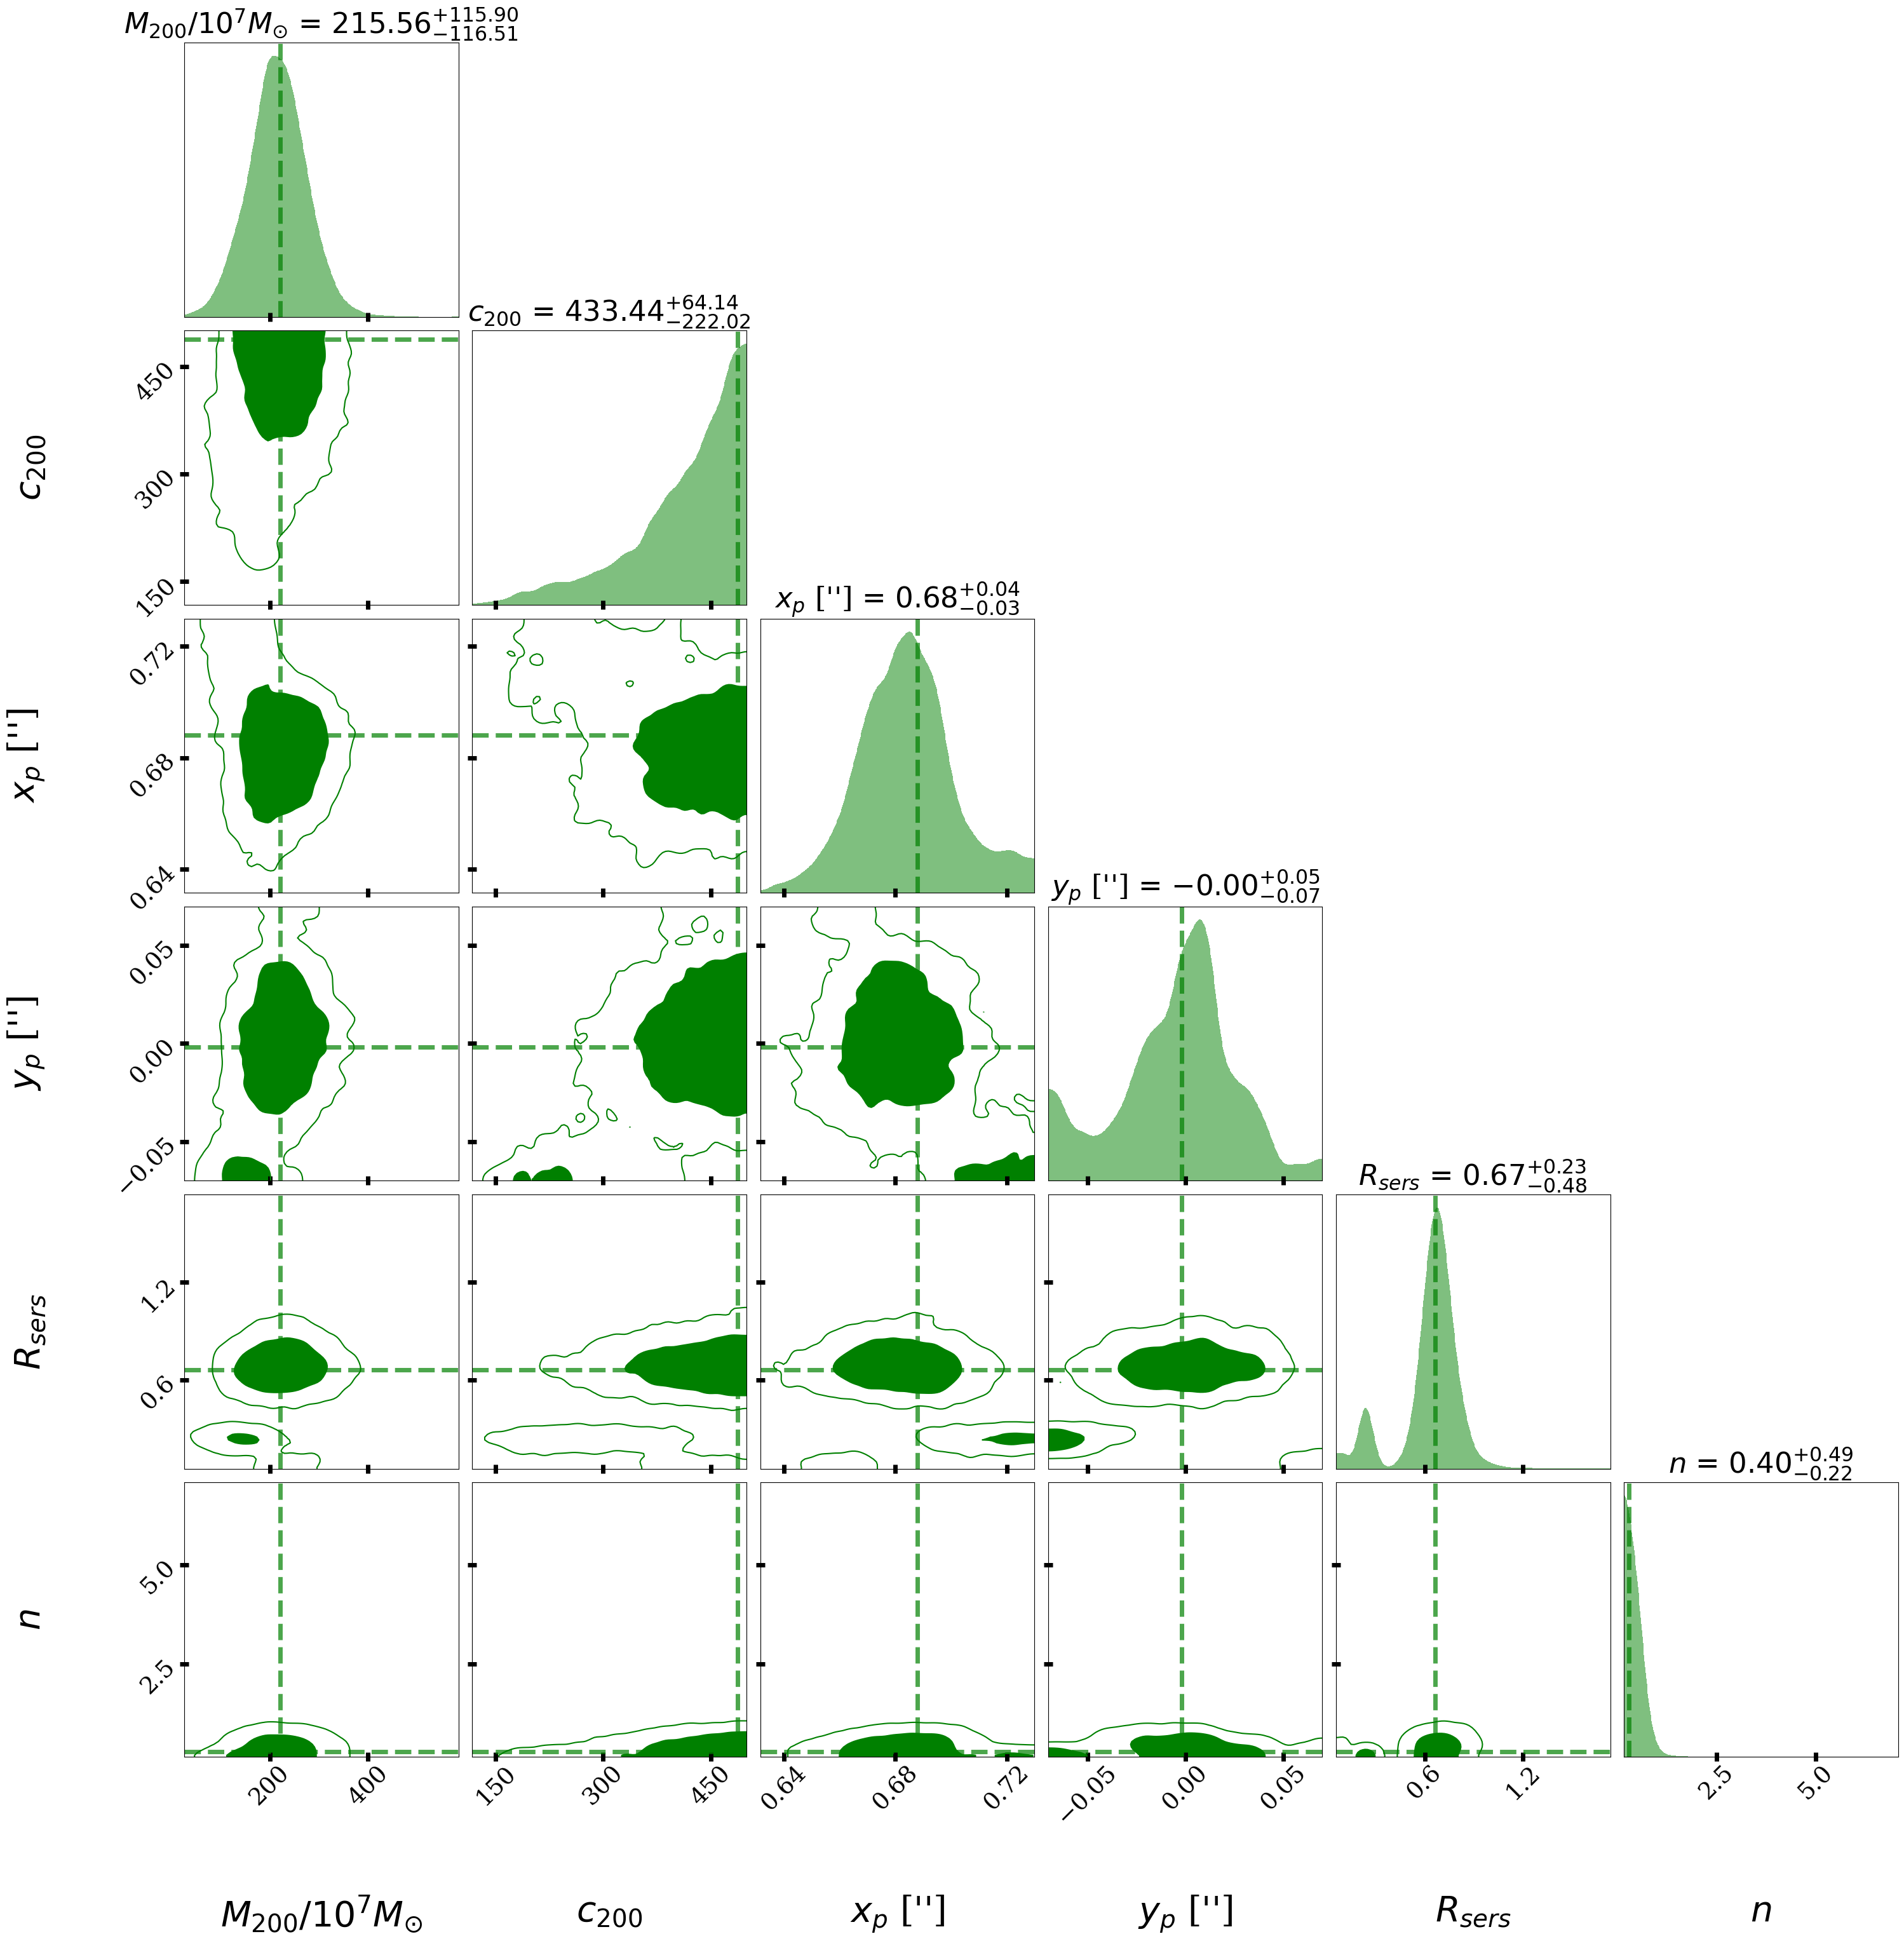

In [2]:
labls_mask = ["$M_{200} / 10^7 M_{\odot}$", '$c_{200}$', "$x_p$ ['']", "$y_p$ ['']", "$R_{sers}$", "$n$"]
lbls = ['M_200', 'c', 'x_p', 'y_p']
sigfigs = [3, 3, 2, 2]

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 27}
matplotlib.rc('font', **font)

truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 6

#nlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

nlist = [18, 19, 20, 21, 22, 23]

labels_plot = []
bestfpp = np.zeros(N)

for i in range(N):
    labels_plot.append(labls_mask[i])
    bestfpp[i] = bestf[nlist[i]]
    print(bestfpp[i])

tfig2,taxes2 = plt.subplots(N,N,figsize=(5*N,5*N))

span = np.ones(N)*0.9995 #[[0.5,5.0],[0.,120.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot,intcbestplot = dresults, bestfpp

tfig2, _ = dyplot.cornerplot(intcplot,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=True,
                                  truths=intcbestplot,truth_color='green',labels=labls_mask,color='green',fig=[tfig2, taxes2],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labls_mask[j], fontsize = 40)
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labls_mask[i], fontsize = 40)
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))

plt.savefig("perturber_posteriors_abell-s1063.png")



In [ ]:
labls_mask = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]',
              '$M_{200}$', 'c', '$x_p$ [arcsec]', '$y_p$ [arcsec]']

truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 22

nlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask[nlist[i]])
    bestfpp[i] = bestf[nlist[i]]


tfig2,taxes2 = plt.subplots(N,N,figsize=(5*N,5*N))

span = np.ones(N)*0.9995#[[0.5,5.0],[0.,120.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot,intcbestplot = dresults, bestfpp

tfig2, _ = dyplot.cornerplot(intcplot,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=True,
                                  truths=intcbestplot,truth_color='magenta',labels=labls_mask,color='magenta',fig=[tfig2, taxes2],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))

plt.savefig("All_posteriors_abell-s1063.png")

#plt.tight_layout()
plt.show()


In [ ]:
import matplotlib as mpl
import matplotlib.lines as lines
import matplotlib.patches as patches


cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

scal = 3.

f, axes = plt.subplots(4, 3, figsize=(15*scal,20*scal))
ax = axes
    
fontsss = 32

txtclr = 'Black'

vmin = 1e-6
vmax = np.nanmax(array200sci)

x_arcsec = bestf[21]
y_arcsec = bestf[20]
x_pixel = x_arcsec / deltaPix
y_pixel = y_arcsec / deltaPix

# Add red circle only in the second column
circle_radius = 0.05/deltaPix  # Adjust the radius as needed
for row in range(3):
    ax[row, 1].add_patch(patches.Circle((60+x_pixel, 60+y_pixel), radius=circle_radius, edgecolor='red', facecolor='none', linewidth=3*scal))

ax[0,0].set_title('#1',fontsize = fontsss*scal, color=txtclr)
ax[0,1].set_title('#2',fontsize = fontsss*scal, color=txtclr)
ax[0,2].set_title('#3',fontsize = fontsss*scal, color=txtclr)

ax[0,0].set_ylabel('Images',fontsize = fontsss*scal, color=txtclr)
ax[1,0].set_ylabel('Reconstructions',fontsize = fontsss*scal, color=txtclr)
ax[2,0].set_ylabel('Residuals',fontsize = fontsss*scal, color=txtclr)

im0 = ax[0,0].imshow(arytst*likemask, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[0,1].imshow(arytst2*likemask2, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[0,2].imshow(arytst3*likemask3, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


x1 = [5,5+1/deltaPix]
y1 = [115,115]

ax[0,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,0].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[0,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,1].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[0,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,2].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,0].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,1].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,2].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[2,0].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,0].text(5,112, '1"', fontsize = fontsss*scal,color='Black')

ax[2,1].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,1].text(5,112, '1"', fontsize = fontsss*scal,color='Black')

ax[2,2].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,2].text(5,112, '1"', fontsize = fontsss*scal,color='Black')

im0 = ax[1,0].imshow(imagevis[2]*likemask, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[1,1].imshow(imagevis[1]*likemask2, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[1,2].imshow(imagevis[0]*likemask3, origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)

vmn = -10.
vmx = 10.

cmap2 = 'bwr'
 
im0 = ax[2,0].imshow((arytst-imagevis[2])*likemask/arytsterr, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)
im0 = ax[2,1].imshow((arytst2-imagevis[1])*likemask2/arytsterr2, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)
im0 = ax[2,2].imshow((arytst3-imagevis[0])*likemask3/arytsterr3, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)

for q in range(0,3):
    for axk in ax[q,:]:
        axk.set_xticklabels([])
        axk.set_yticklabels([])

        axk.set_xticks([])
        axk.set_yticks([])

        for direc in ['left', 'right', 'top', 'bottom']:

            axk.spines[direc].set_color('red') 
            axk.spines[direc].set_linewidth(3*scal)

#f.colorbar(im0, ax=axes)
#plt.plot(x1,y1,color="white", linewidth=3*scal,linestyle='dashed')
#f.add_artist(lines.Line2D([-0.01, 1.01], [1.01, -0.01],alpha=0.))
f.add_artist(lines.Line2D([-0.01,1.01], [0.5,0.5],alpha=0.))

vmins = np.log10(np.nanmax(sourcevis))-2.5
vmaxs = np.log10(np.nanmax(sourcevis))

ax = axes
gs = axes[0,0].get_gridspec()
axbig = axes[3,0]

im0 = axbig.imshow(np.log10(sourcevis), origin='upper', vmin=vmins, vmax=vmaxs, cmap=cmap)

#axbig.set_xlim(400,600)
#axbig.set_ylim(400,600)

axbig.set_xticks([])
axbig.set_yticks([])

axbig.set_xticklabels([])
axbig.set_yticklabels([])

for direc in ['left', 'right', 'top', 'bottom']:

    axbig.spines[direc].set_color('red') 
    axbig.spines[direc].set_linewidth(3*scal)

axbig.set_ylabel('Source Model',fontsize = fontsss*scal, color=txtclr)

deltaPix_s = 0.002

scaleg = 6

x1s = [5*scaleg,5*scaleg+0.2*2/deltaPix_s]
y1s = [115*scaleg,115*scaleg]
axbig.add_artist(lines.Line2D(x1s, y1s,color="white", linewidth=3*scal))
axbig.text(5*scaleg,112*scaleg, '0.2"', fontsize = fontsss*scal,color='White')

axes[3,1].remove()
axes[3,2].remove()

plt.tight_layout()

f.savefig("Reconstruction_Residuals_with-masks_abell-s1063.png")


import matplotlib as mpl
import matplotlib.lines as lines


cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

scal = 3.

f, axes = plt.subplots(4, 3, figsize=(15*scal,20*scal))
ax = axes
    
    
fontsss = 32

txtclr = 'Black'

vmin = np.nanmax(np.log10(array200sci))-1.5
vmax = np.nanmax(np.log10(array200sci))

# Add red circle only in the second column
circle_radius = 0.05/deltaPix  # Adjust the radius as needed
for row in range(3):
    ax[row, 1].add_patch(patches.Circle((60+x_pixel, 60+y_pixel), radius=circle_radius, edgecolor='magenta', facecolor='none', linewidth=3*scal))


ax[0,0].set_title('#1',fontsize = fontsss*scal, color=txtclr)
ax[0,1].set_title('#2',fontsize = fontsss*scal, color=txtclr)
ax[0,2].set_title('#3',fontsize = fontsss*scal, color=txtclr)

ax[0,0].set_ylabel('Images',fontsize = fontsss*scal, color=txtclr)
ax[1,0].set_ylabel('Reconstructions',fontsize = fontsss*scal, color=txtclr)
ax[2,0].set_ylabel('Residuals',fontsize = fontsss*scal, color=txtclr)

im0 = ax[0,0].imshow(np.log10(arytst*likemask), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[0,1].imshow(np.log10(arytst2*likemask2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[0,2].imshow(np.log10(arytst3*likemask3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


x1 = [5,5+1/deltaPix]
y1 = [115,115]

ax[0,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,0].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[0,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,1].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[0,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0,2].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,0].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,1].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[1,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1,2].text(5,112, '1"', fontsize = fontsss*scal,color='White')

ax[2,0].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,0].text(5,112, '1"', fontsize = fontsss*scal,color='Black')

ax[2,1].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,1].text(5,112, '1"', fontsize = fontsss*scal,color='Black')

ax[2,2].add_artist(lines.Line2D(x1, y1,color="Black", linewidth=3*scal))
ax[2,2].text(5,112, '1"', fontsize = fontsss*scal,color='Black')



im0 = ax[1,0].imshow(np.log10(imagevis[2]*likemask), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[1,1].imshow(np.log10(imagevis[1]*likemask2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[1,2].imshow(np.log10(imagevis[0]*likemask3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


vmn = -10.
vmx = 10.

cmap2 = 'bwr'
 

im0 = ax[2,0].imshow((arytst-imagevis[2])*likemask/arytsterr, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)
im0 = ax[2,1].imshow((arytst2-imagevis[1])*likemask2/arytsterr2, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)
im0 = ax[2,2].imshow((arytst3-imagevis[0])*likemask3/arytsterr3, origin='upper', vmin=vmn, vmax=vmx, cmap=cmap2)

for q in range(0,3):
    for axk in ax[q,:]:
        axk.set_xticklabels([])
        axk.set_yticklabels([])

        axk.set_xticks([])
        axk.set_yticks([])

        for direc in ['left', 'right', 'top', 'bottom']:

            axk.spines[direc].set_color('red') 
            axk.spines[direc].set_linewidth(3*scal)

#f.colorbar(im0, ax=axes)
#plt.plot(x1,y1,color="white", linewidth=3*scal,linestyle='dashed')
#f.add_artist(lines.Line2D([-0.01, 1.01], [1.01, -0.01],alpha=0.))
f.add_artist(lines.Line2D([-0.01,1.01], [0.5,0.5],alpha=0.))

vmins = np.log10(np.nanmax(sourcevis))-2.5
vmaxs = np.log10(np.nanmax(sourcevis))

ax = axes
gs = axes[0,0].get_gridspec()
axbig = axes[3,0]

im0 = axbig.imshow(np.log10(sourcevis), origin='upper', vmin=vmins, vmax=vmaxs, cmap=cmap)

#axbig.set_xlim(400,600)
#axbig.set_ylim(400,600)

axbig.set_xticks([])
axbig.set_yticks([])

axbig.set_xticklabels([])
axbig.set_yticklabels([])

for direc in ['left', 'right', 'top', 'bottom']:

    axbig.spines[direc].set_color('red') 
    axbig.spines[direc].set_linewidth(3*scal)

axbig.set_ylabel('Source Model',fontsize = fontsss*scal, color=txtclr)

deltaPix_s = 0.002

scaleg = 6

x1s = [5*scaleg,5*scaleg+0.2*2/deltaPix_s]
y1s = [115*scaleg,115*scaleg]
axbig.add_artist(lines.Line2D(x1s, y1s,color="white", linewidth=3*scal))
axbig.text(5*scaleg,112*scaleg, '0.2"', fontsize = fontsss*scal,color='White')


axes[3,1].remove()
axes[3,2].remove()

plt.tight_layout()
f.savefig("Reconstruction_Residuals_wo-masks_abell-s1063.png")